In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv("../notebook/provider_fraud_features.csv")
df.head()

,Provider,In_TotalClaims,In_AvgDiagnosisCount,In_AvgProcedureCount,In_PctFullDiagnosis,In_PctHighProcedure,In_AvgProcDiagRatio,Out_TotalClaims,Out_AvgDiagnosisCount,Out_AvgProcedureCount,Out_PctFullDiagnosis,Out_PctHasProcedure,Out_AvgProcDiagRatio,PotentialFraud
0,PRV51001,5.0,7.200000,0.600000,0.000000,0.0,0.068571,20.0,9.000000,0.0,0.000000,0.0,0.0,0
1,PRV51003,62.0,8.112903,0.774194,0.064516,0.0,0.093941,70.0,8.444444,0.0,0.014286,0.0,0.0,1
2,PRV51004,0.0,0.000000,0.000000,0.000000,0.0,0.000000,149.0,7.333333,0.0,0.006711,0.0,0.0,0
3,PRV51005,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1165.0,8.060976,0.0,0.007725,0.0,0.0,1
4,PRV51007,3.0,7.333333,0.333333,0.000000,0.0,0.041667,69.0,9.500000,0.0,0.028986,0.0,0.0,0


In [4]:
df.columns

Index(['Provider', 'In_TotalClaims', 'In_AvgDiagnosisCount',
       'In_AvgProcedureCount', 'In_PctFullDiagnosis', 'In_PctHighProcedure',
       'In_AvgProcDiagRatio', 'Out_TotalClaims', 'Out_AvgDiagnosisCount',
       'Out_AvgProcedureCount', 'Out_PctFullDiagnosis', 'Out_PctHasProcedure',
       'Out_AvgProcDiagRatio', 'PotentialFraud'],
      dtype='object')

In [5]:
df['PotentialFraud'].isnull().sum()

0

In [6]:
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud']

In [7]:
X.shape

(5410, 12)

In [8]:
y.shape

(5410,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        class_weight = 'balanced',
        max_iter = 1000,
        random_state = 42
    ))
])

In [11]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [12]:
y_pred = pipe.predict(X_test)

In [13]:
y_prob = pipe.predict(X_test)
y_prob

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [14]:
y_prob = pipe.predict_proba(X_test)[:, 1]
y_prob

array([0.07723135, 0.05354037, 0.06773232, ..., 0.06962671, 0.25212094,
       0.40208259])

In [15]:
report = classification_report(y_test, y_pred)

In [16]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       977
           1       0.39      0.80      0.53       105

    accuracy                           0.86      1082
   macro avg       0.69      0.83      0.72      1082
weighted avg       0.92      0.86      0.88      1082



In [17]:
"ROC-AUC:", roc_auc_score(y_test, y_prob)

('ROC-AUC:', 0.9234244772627578)

In [38]:
for t in [0.3, 0.4, 0.5, 0.6]:
    y_pred = (y_prob >= t).astype(int)
    print(y_pred)

[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [19]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_prob)

0.6531901129480893

# EDA after Baseline Model is trained

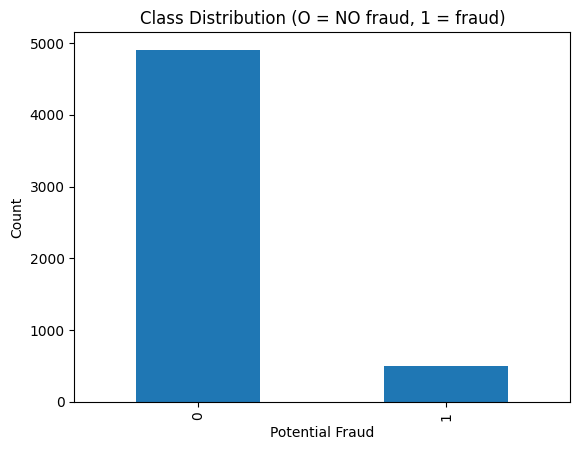

In [20]:
df['PotentialFraud'].value_counts().plot(kind = 'bar')
plt.xlabel("Potential Fraud")
plt.ylabel("Count")
plt.title("Class Distribution (O = NO fraud, 1 = fraud)")
plt.show()

In [21]:
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef': pipe.named_steps['lr'].coef_[0]
})

coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df.sort_values('abs_coef', ascending=False).head(10)


,feature,coef,abs_coef
0,In_TotalClaims,1.786588,1.786588
6,Out_TotalClaims,1.181186,1.181186
1,In_AvgDiagnosisCount,0.740839,0.740839
9,Out_PctFullDiagnosis,-0.346847,0.346847
5,In_AvgProcDiagRatio,0.136023,0.136023
7,Out_AvgDiagnosisCount,0.112669,0.112669
10,Out_PctHasProcedure,0.092624,0.092624
2,In_AvgProcedureCount,0.080782,0.080782
4,In_PctHighProcedure,-0.061786,0.061786
8,Out_AvgProcedureCount,-0.032425,0.032425


In [22]:
pipe.named_steps


{'scaler': StandardScaler(),
 'lr': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)}

In [23]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [24]:
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(
        n_estimators = 500,
        min_samples_leaf = 5,
        class_weight = 'balanced',
        random_state = 42,
        n_jobs = -1
    ))
])

In [25]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=5, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

In [26]:
y_pred_rf = rf_pipe.predict(X_test)

In [27]:
y_prob_rf = rf_pipe.predict_proba(X_test)[:,1]
y_prob_rf

array([0.01198449, 0.00707023, 0.01626837, ..., 0.01743234, 0.30786746,
       0.20779012])

In [28]:
report_rf = classification_report(y_test, y_pred_rf)

In [29]:
print(report_rf)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       977
           1       0.50      0.63      0.56       105

    accuracy                           0.90      1082
   macro avg       0.73      0.78      0.75      1082
weighted avg       0.91      0.90      0.91      1082



In [30]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       977
           1       0.39      0.80      0.53       105

    accuracy                           0.86      1082
   macro avg       0.69      0.83      0.72      1082
weighted avg       0.92      0.86      0.88      1082



In [31]:
"ROC-AUC:", roc_auc_score(y_test, y_prob_rf)

('ROC-AUC:', 0.9169371740507871)

In [32]:
rf_model = rf_pipe.named_steps['rf']

rf_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

rf_imp.head(10)

,feature,importance
0,In_TotalClaims,0.232103
6,Out_TotalClaims,0.165989
3,In_PctFullDiagnosis,0.120462
5,In_AvgProcDiagRatio,0.118950
2,In_AvgProcedureCount,0.116717
1,In_AvgDiagnosisCount,0.082897
7,Out_AvgDiagnosisCount,0.052273
9,Out_PctFullDiagnosis,0.051185
4,In_PctHighProcedure,0.039504
8,Out_AvgProcedureCount,0.010633


In [33]:
threshold = 0.6
y_pred_rf_tuned = (y_prob_rf >= threshold).astype(int)
print(classification_report(y_test, y_pred_rf_tuned))


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       977
           1       0.55      0.54      0.55       105

    accuracy                           0.91      1082
   macro avg       0.75      0.75      0.75      1082
weighted avg       0.91      0.91      0.91      1082



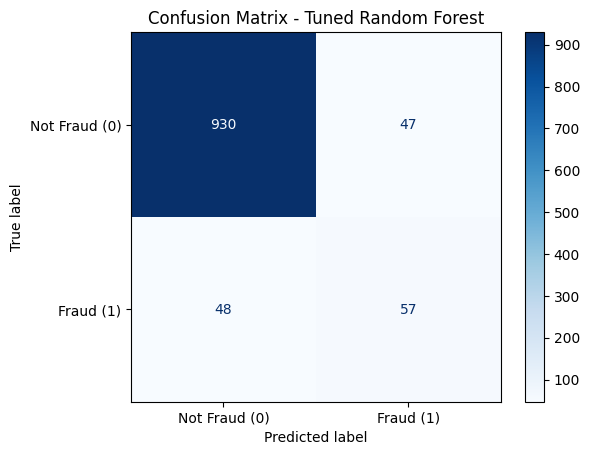

In [34]:
cm = confusion_matrix(y_test, y_pred_rf_tuned)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Fraud (0)", "Fraud (1)"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()

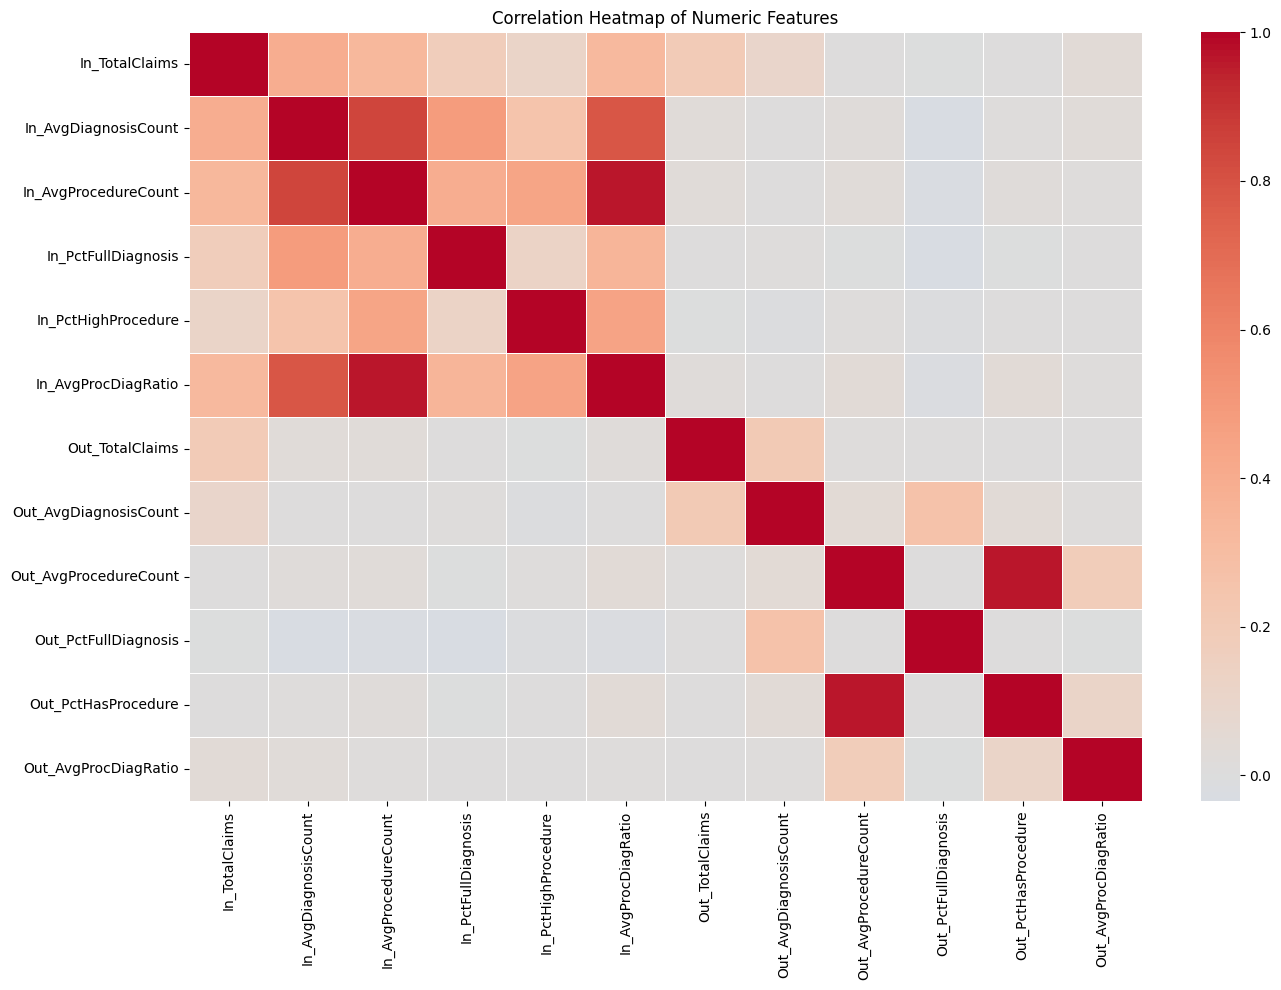

Fraud                    1.000000
In_TotalClaims           0.529559
Out_TotalClaims          0.336165
In_AvgDiagnosisCount     0.310787
In_AvgProcedureCount     0.278230
In_AvgProcDiagRatio      0.267665
In_PctFullDiagnosis      0.143318
Out_AvgDiagnosisCount    0.107706
In_PctHighProcedure      0.082282
Out_AvgProcDiagRatio     0.057216
Out_AvgProcedureCount    0.037826
Out_PctHasProcedure      0.035600
Out_PctFullDiagnosis    -0.015674
Name: Fraud, dtype: float64


In [35]:
numeric_df = X_train.select_dtypes(include=["int64", "float64"])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

# OPTIONAL: correlation with target (fraud)
numeric_with_target = numeric_df.copy()
numeric_with_target["Fraud"] = y_train

corr_with_target = numeric_with_target.corr()["Fraud"].sort_values(ascending=False)
print(corr_with_target)

In [36]:
df.head()

,Provider,In_TotalClaims,In_AvgDiagnosisCount,In_AvgProcedureCount,In_PctFullDiagnosis,In_PctHighProcedure,In_AvgProcDiagRatio,Out_TotalClaims,Out_AvgDiagnosisCount,Out_AvgProcedureCount,Out_PctFullDiagnosis,Out_PctHasProcedure,Out_AvgProcDiagRatio,PotentialFraud
0,PRV51001,5.0,7.200000,0.600000,0.000000,0.0,0.068571,20.0,9.000000,0.0,0.000000,0.0,0.0,0
1,PRV51003,62.0,8.112903,0.774194,0.064516,0.0,0.093941,70.0,8.444444,0.0,0.014286,0.0,0.0,1
2,PRV51004,0.0,0.000000,0.000000,0.000000,0.0,0.000000,149.0,7.333333,0.0,0.006711,0.0,0.0,0
3,PRV51005,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1165.0,8.060976,0.0,0.007725,0.0,0.0,1
4,PRV51007,3.0,7.333333,0.333333,0.000000,0.0,0.041667,69.0,9.500000,0.0,0.028986,0.0,0.0,0


In [37]:
df.columns

Index(['Provider', 'In_TotalClaims', 'In_AvgDiagnosisCount',
       'In_AvgProcedureCount', 'In_PctFullDiagnosis', 'In_PctHighProcedure',
       'In_AvgProcDiagRatio', 'Out_TotalClaims', 'Out_AvgDiagnosisCount',
       'Out_AvgProcedureCount', 'Out_PctFullDiagnosis', 'Out_PctHasProcedure',
       'Out_AvgProcDiagRatio', 'PotentialFraud'],
      dtype='object')